In [1]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [3]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


# Exercise 1

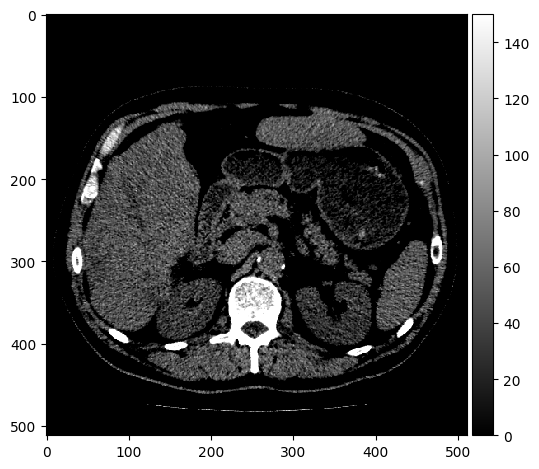

In [9]:
io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

# Exercise 2

In [35]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

# Calculate average and standard deviation of spleen values
spleen_mean = np.mean(spleen_values)
spleen_std = np.std(spleen_values)

# Print the results
print('Mean:', spleen_mean)
print('Standard deviation:', spleen_std)

Mean: 49.48026905829597
Standard deviation: 14.9970794143059


Yes they correspond to the values above

# Exercise 3

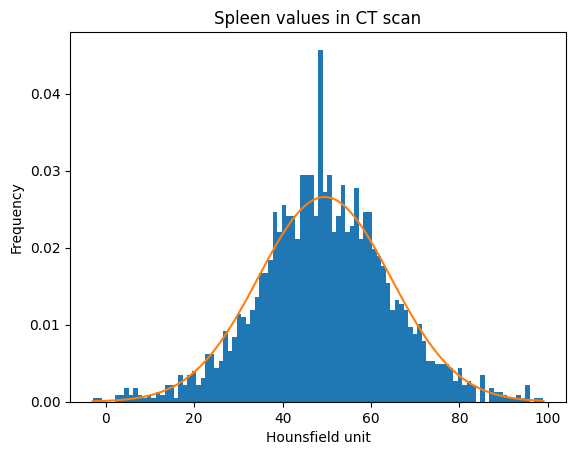

In [29]:
n, bins, patches = plt.hist(bone_values, 100, density=1)
pdf_spleen = norm.pdf(bins, spleen_mean, spleen_std)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

They look gaussian distributed

# Exercise 4

In [30]:
def values_from_mask(img, mask_file):
    roi = io.imread(in_dir + mask_file)
    # convert to boolean image
    mask = roi > 0
    return img[mask]

In [49]:
bone_values = values_from_mask(img, 'BoneROI.png')
fat_values = values_from_mask(img, 'FatROI.png')
liver_values = values_from_mask(img, 'LiverROI.png')
kidney_values = values_from_mask(img, 'KidneyROI.png')

mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

mu_fat = np.mean(fat_values)
std_fat = np.std(fat_values)

mu_liver = np.mean(liver_values)
std_liver = np.std(liver_values)

mu_kidney = np.mean(kidney_values)
std_kidney = np.std(kidney_values)

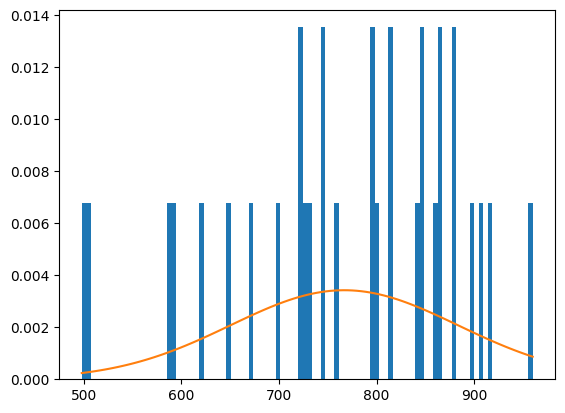

In [36]:
mean = np.mean(bone_values)
std = np.std(bone_values)
n, bins, patches = plt.hist(bone_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

Not gaussian ^

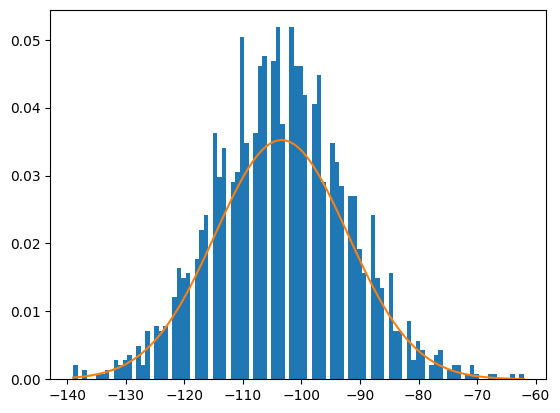

In [37]:
mean = np.mean(fat_values)
std = np.std(fat_values)
n, bins, patches = plt.hist(fat_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

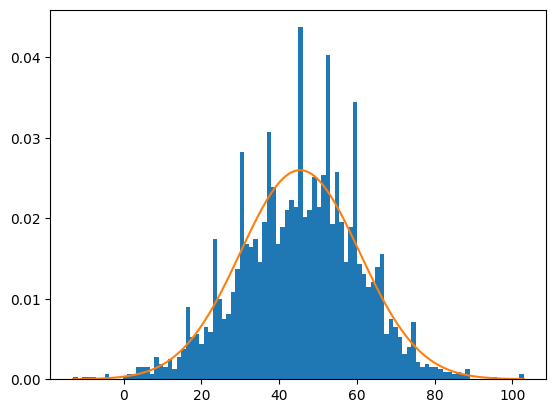

In [38]:
mean = np.mean(liver_values)
std = np.std(liver_values)
n, bins, patches = plt.hist(liver_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

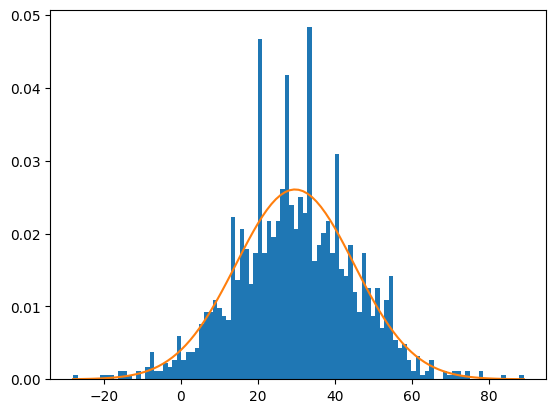

In [39]:
mean = np.mean(kidney_values)
std = np.std(kidney_values)
n, bins, patches = plt.hist(kidney_values, 100, density=1)
pdf = norm.pdf(bins, mean, std)
plt.plot(bins, pdf)

# Exercise 5

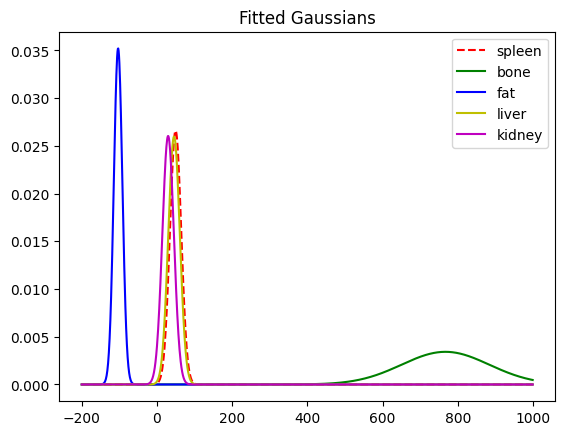

In [42]:
# Hounsfield unit limits of the plot
min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_liver = norm.pdf(hu_range, mu_liver, std_liver)
pdf_kidney = norm.pdf(hu_range, mu_kidney, std_kidney)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.plot(hu_range, pdf_fat, 'b', label="fat")
plt.plot(hu_range, pdf_liver, 'y', label="liver")
plt.plot(hu_range, pdf_kidney, 'm', label="kidney")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

Fat and bone are easy to seperate. Kidney, spleen and liver will be hard since they are ontop of each other

# Exercise 6

We can make the classes fat, bone, and organs. Organs will be liver, kidney and spleen combined.

# Exercise 7

In [58]:
soft_tissue = np.append(spleen_values, liver_values)
soft_tissue = np.append(soft_tissue, kidney_values)
mu_soft = np.mean(soft_tissue)
std_soft = np.std(soft_tissue)

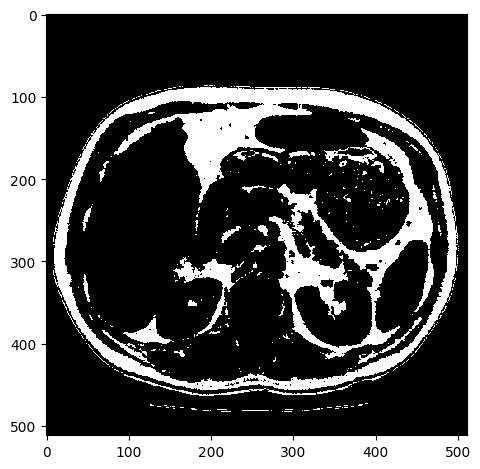

In [59]:
t_background = -200

# Find midpoint between fat and soft tissue
t_fat_soft = (mu_fat + mu_soft) / 2

# Combine spleen, liver and kidney values into new value called soft tissue
fat_img = (img > t_background) & (img <= t_fat_soft)
io.imshow(fat_img, cmap='gray')
io.show()